In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, LSTM, Flatten, TimeDistributed, BatchNormalization, Activation
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

tf.random.set_seed(30)

import pandas as pd
import numpy as np
import os
import sys
import random
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from IPython.display import Audio

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
Ravdess = "/content/drive/MyDrive/deep_term_project/archive/audio_speech_actors_01-24/"

In [5]:
ravdess_directory_list = os.listdir(Ravdess)
file_emotion = []
file_statement = []
file_path = []
for dir in ravdess_directory_list:
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        file_emotion.append(int(part[2]))
        file_statement.append(int(part[4]))
        file_path.append(Ravdess + dir + '/' + file)

Ravdess_df = pd.DataFrame({"Emotions":file_emotion, "Statement":file_statement, "Path":file_path})
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

Emotions  Statement                                               Path
0  neutral          2  /content/drive/MyDrive/deep_term_project/archi...
1  neutral          1  /content/drive/MyDrive/deep_term_project/archi...
2     calm          2  /content/drive/MyDrive/deep_term_project/archi...
3  neutral          1  /content/drive/MyDrive/deep_term_project/archi...
4     calm          1  /content/drive/MyDrive/deep_term_project/archi...

In [4]:
Ravdess_df.shape

(1440, 3)

In [6]:
Ravdess_df.groupby(['Emotions','Statement']).size().unstack()

Statement   1   2
Emotions         
angry      96  96
calm       96  96
disgust    96  96
fear       96  96
happy      96  96
neutral    48  48
sad        96  96
surprise   96  96

In [7]:
# create a copy
data_path = Ravdess_df[['Emotions','Path']].copy()
data_path.to_csv("data_path.csv",index=False)
data_path.head()

Emotions                                               Path
0  neutral  /content/drive/MyDrive/deep_term_project/archi...
1  neutral  /content/drive/MyDrive/deep_term_project/archi...
2     calm  /content/drive/MyDrive/deep_term_project/archi...
3  neutral  /content/drive/MyDrive/deep_term_project/archi...
4     calm  /content/drive/MyDrive/deep_term_project/archi...

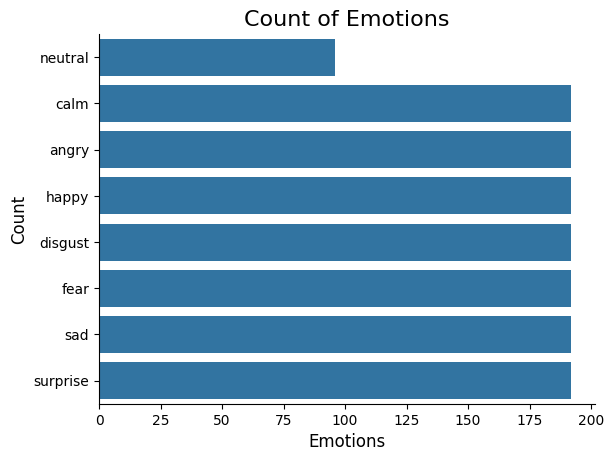

In [8]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [9]:
def create_waveplot(data, sr):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio', size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio', size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

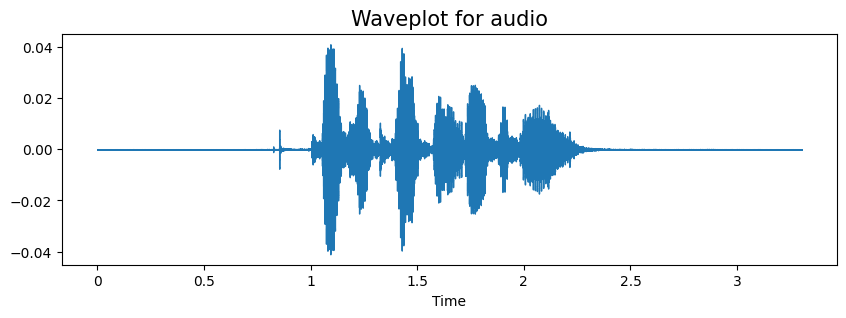

In [10]:
path = "/content/drive/MyDrive/deep_term_project/archive/Actor_01/03-01-01-01-01-01-01.wav"
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate)
Audio(path)

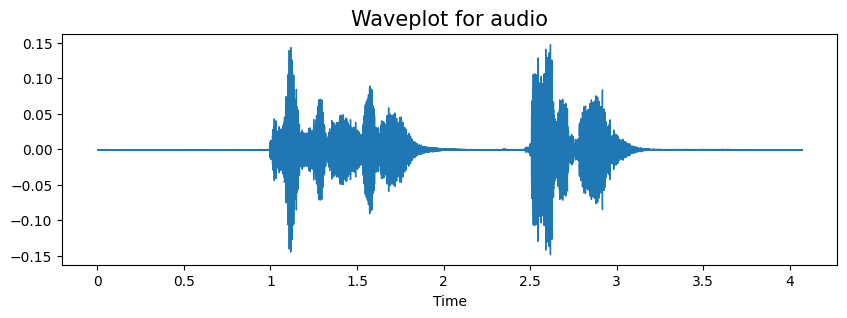

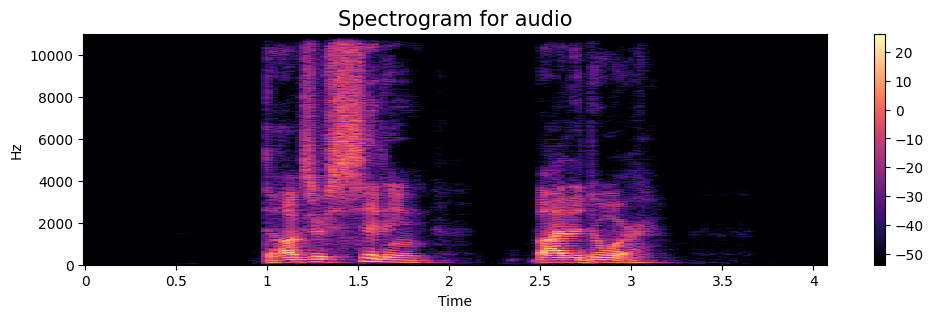

In [11]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate)
create_spectrogram(data, sampling_rate)
Audio(path)

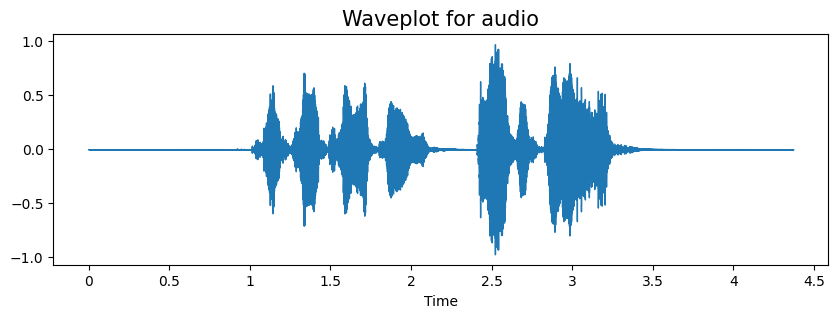

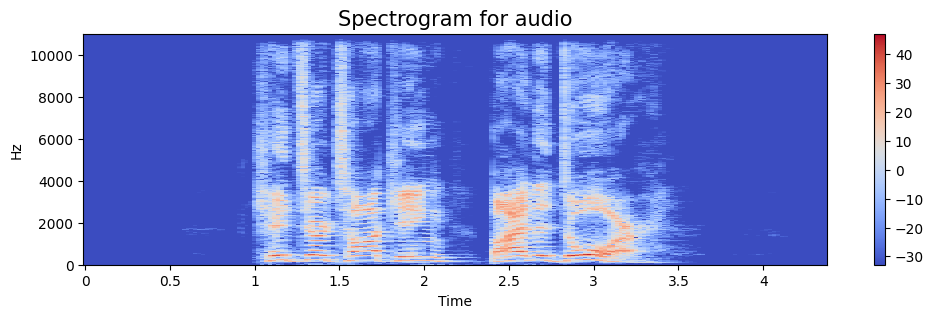

In [12]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate)
create_spectrogram(data, sampling_rate)
Audio(path)

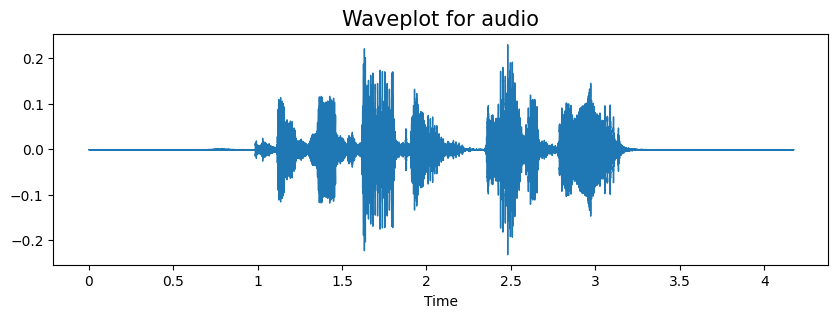

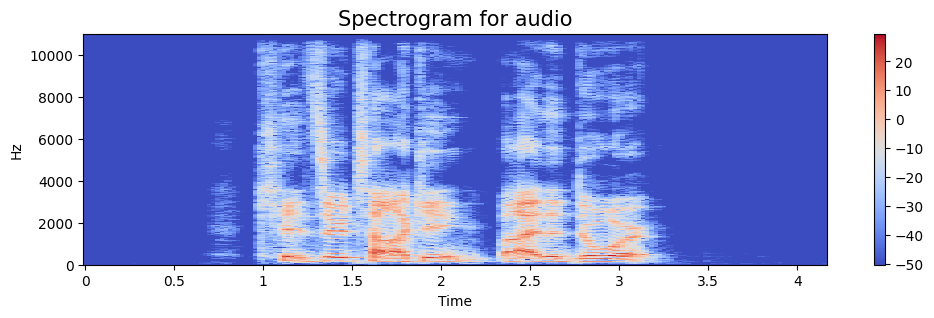

In [13]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate)
create_spectrogram(data, sampling_rate)
Audio(path)

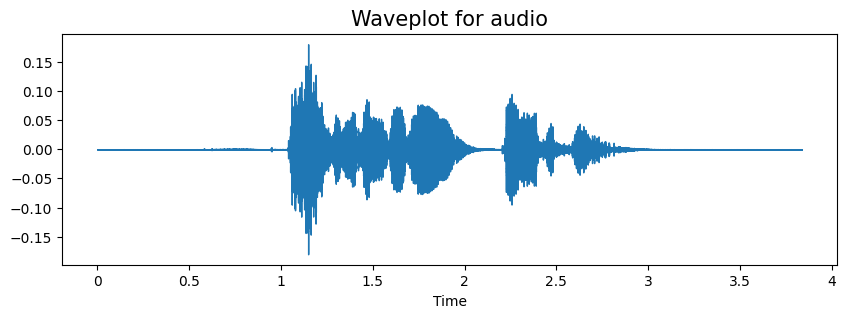

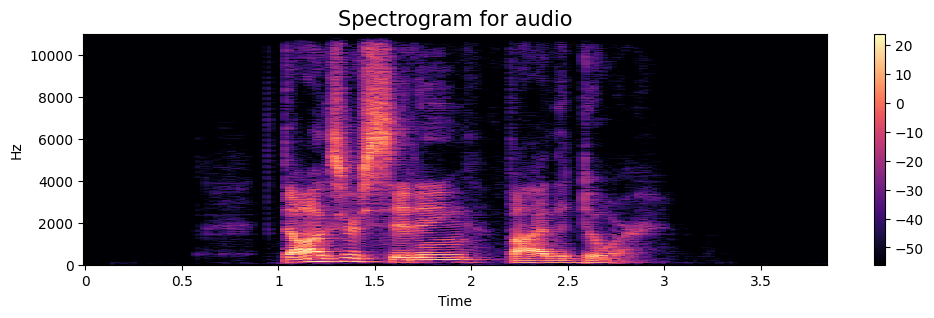

In [14]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate)
create_spectrogram(data, sampling_rate)
Audio(path)

In [15]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate):
    return librosa.effects.time_stretch(y=data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)

In [16]:
# take a example and check for technique.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

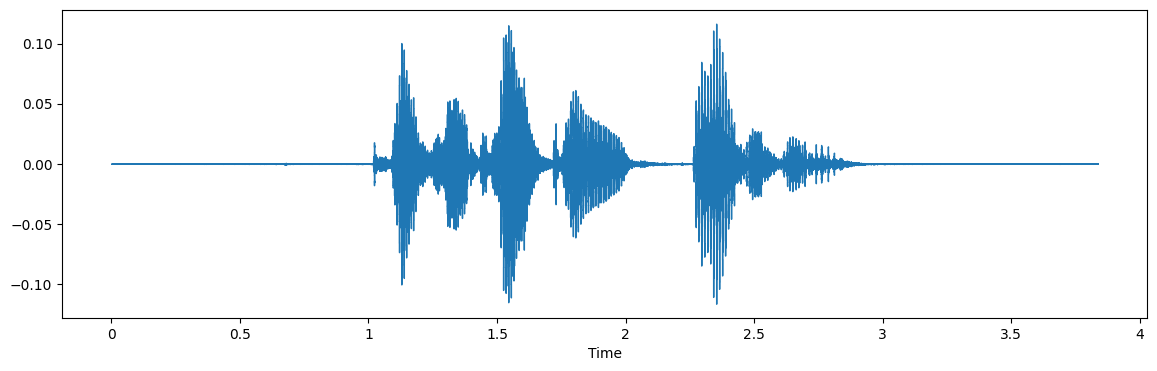

In [17]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

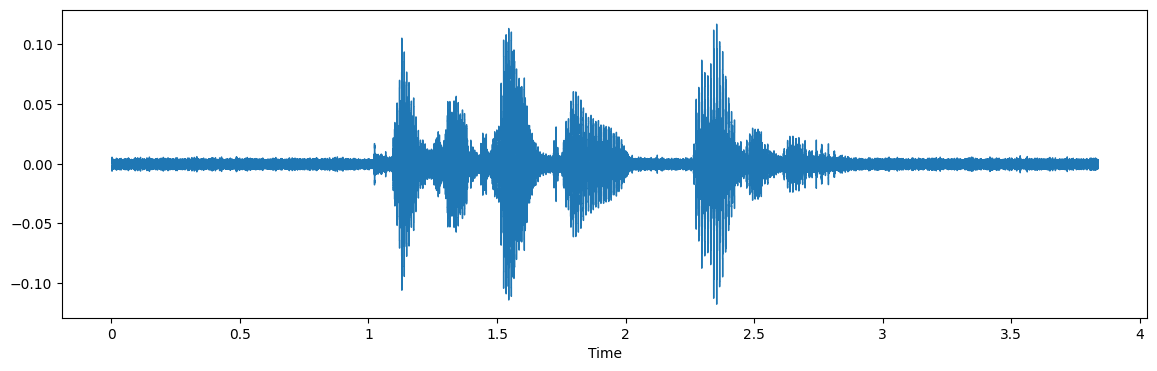

In [18]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

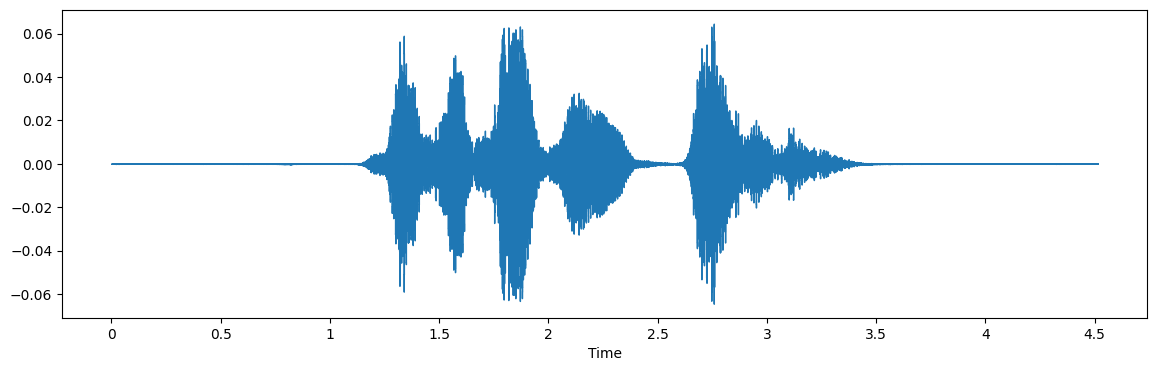

In [19]:
x = stretch(data, rate=0.85)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

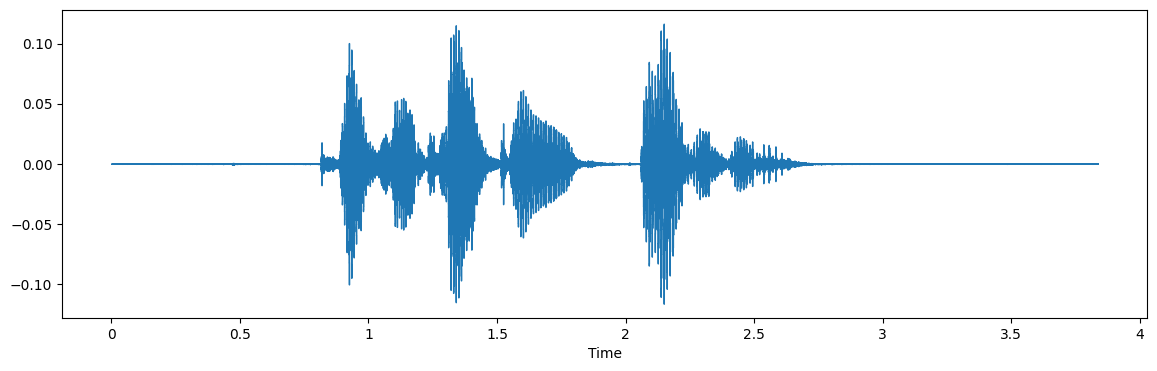

In [20]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

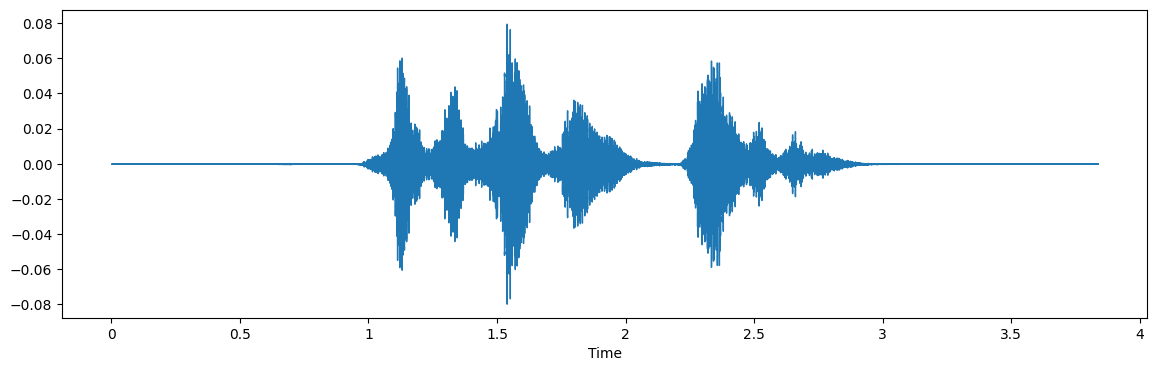

In [21]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

In [23]:
def extract_features(data):
    mfcc = librosa.feature.mfcc(y=data, sr=sample_rate)
    result = mfcc
    return result

In [24]:
def transform_audio(data, fns):
    fn = random.choice(fns)
    if fn == pitch:
        fn_data = fn(data, sampling_rate)
    elif fn == "None":
        fn_data = data
    elif fn in [noise, stretch]:
        fn_data = fn(data)
    else:
        fn_data = data
    return fn_data

In [25]:
def get_features(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    fns = [noise, pitch, "None"]
    fn1_data = transform_audio(data, fns)
    fn2_data = transform_audio(fn1_data, fns)
    res1 = extract_features(fn2_data)
    result = [np.array(res1[:,:108])]
    fn1_data = transform_audio(data, fns)
    fn2_data = transform_audio(fn1_data, fns)
    res2 = extract_features(fn2_data)[:,:108]
    result.append(res2)
    fn1_data = transform_audio(data, fns)
    fn2_data = transform_audio(fn1_data, fns)
    res3 = extract_features(fn2_data)[:,:108]
    result.append(res3)
    return result

In [26]:
path = "/content/drive/MyDrive/deep_term_project/archive/Actor_01/03-01-01-01-01-01-01.wav"
data, sampling_rate = librosa.load(path, duration=2.5, offset=0.6)
Audio(path)
xx1 = librosa.feature.zero_crossing_rate(data)
stft = np.abs(librosa.stft(data))
xx2 = librosa.feature.chroma_stft(S=stft, sr=sample_rate)
xx3 = librosa.feature.mfcc(y=data, sr=sample_rate)
xx4 = librosa.feature.rms(y=data)
xx5 = librosa.feature.melspectrogram(y=data, sr=sample_rate)
xx1.shape, xx2.shape, xx3.shape, xx4.shape, xx5.shape, np.append(xx1,xx2,axis=0).shape

((1, 108), (12, 108), (20, 108), (1, 108), (128, 108), (13, 108))

In [27]:
X, Y = [], []
for path, emotion in zip(data_path.Path.to_list(), data_path.Emotions.to_list()):
    feature = get_features(path)
    for ele in feature:
        if ele.shape == (20, 108):
            X.append(ele)
            Y.append(emotion)
        else:
            print(ele.shape)

(20, 103)
(20, 103)
(20, 103)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 105)
(20, 105)
(20, 105)
(20, 101)
(20, 101)
(20, 101)
(20, 105)
(20, 105)
(20, 105)
(20, 104)
(20, 104)
(20, 104)


In [28]:
len(X), len(Y), data_path.Path.shape

(4275, 4275, (1440,))

In [29]:
dfm = pd.DataFrame()
xx = pd.Series(X)
for i in range(20):
    dfm[i] = [k[i] for k in xx]

Features = dfm.copy()
Features['labels'] = Y
Features.head()

0  \
0  [-423.35746783561285, -392.7405739717685, -392...   
1  [-742.0388, -730.8672, -755.06036, -768.99835,...   
2  [-642.9454090787132, -616.4653096929013, -629....   
3  [-397.4253024042027, -368.7552479950341, -380....   
4  [-811.2001, -811.2992, -797.46124, -777.3617, ...   

                                                   1  \
0  [1.7424047529788647, -0.2762501959411343, -0.1...   
1  [46.281334, 49.612473, 38.95497, 31.231647, 19...   
2  [14.705570005212502, 7.738801387325122, 5.8051...   
3  [6.0547960196146136, 0.9977771446069603, 0.342...   
4  [19.628521, 18.06759, 25.862562, 34.08587, 27....   

                                                   2  \
0  [-2.769928276596861, 0.11853653325633096, 3.96...   
1  [-8.70231, -11.109249, -0.9371706, 0.95351547,...   
2  [2.6520144159530377, -0.48667071930764244, -3....   
3  [0.9670262211355685, -1.931100693663958, -3.60...   
4  [18.331585, 15.919741, 14.387458, 9.771994, 4....   

                                                   3  \
0  [-1.8220289486510222, -2.8782841597890365, 0.3...   
1  [3.1488822, 7.6340494, 9.989678, 9.106522, 5.4...   
2  [1.4896434319661254, 2.997053957277773, 6.9198...   
3  [3.8350187677485073, 2.945942560635297, -1.042...   
4  [16.306522, 14.202408, 14.217077, 14.61382, 13...   

                                                   4  \
0  [-1.0228391778098262, -2.2703585220761364, -0....   
1  [18.238642, 16.050514, 15.748805, 18.48889, 15...   
2  [2.8922321862522846, -0.8125276868054053, 2.73...   
3  [2.3414956422044813, 2.794107474833601, -0.208...   
4  [13.740545, 10.654496, 10.9737015, 6.0953655, ...   

                                                   5  \
0  [-0.2041765194467074, -0.1475724426478524, -1....   
1  [8.380125, 2.9630573, 2.3721967, 7.6347175, 8....   
2  [0.5469867610939496, -4.611005987879602, -4.28...   
3  [1.910409609122777, 1.6436253561801677, 1.9262...   
4  [10.863268, 7.3858156, 5.3280787, 0.4004135, -...   

                                                   6  \
0  [1.5667423767396997, 2.690719024097271, 1.2482...   
1  [-12.314074, -14.79368, -14.192249, -7.256242,...   
2  [-9.35893482090405, -11.102677808414786, -14.4...   
3  [-5.490755308031089, -6.150727999897625, -5.59...   
4  [7.919695, 4.0530643, -1.6818023, -8.332315, -...   

                                                   7  \
0  [6.000097914243905, 4.2894315480671965, -0.005...   
1  [-23.689348, -26.057865, -21.613775, -11.56756...   
2  [-3.8993656695774193, -3.8215378481768756, -1....   
3  [3.3488308083696054, 2.1198011626070152, -1.25...   
4  [5.1421976, 1.1447223, -5.095977, -12.240641, ...   

                                                   8  \
0  [7.302674062670177, 5.367702863049127, 1.64900...   
1  [-5.0755234, -4.768344, -3.943965, 1.2800754, ...   
2  [-3.6104363822755756, -8.934110059933422, -9.6...   
3  [0.43298359752824156, 1.777697885820598, 1.341...   
4  [2.7254505, 0.7520218, 2.297258, 1.8483117, 1....   

                                                   9  ...  \
0  [4.672105898260498, 2.3418246842338024, -1.487...  ...   
1  [14.452238, 11.188458, 9.426402, 11.875672, 14...  ...   
2  [3.4510914959471894, 3.3300831611787247, 1.954...  ...   
3  [2.8105289864205423, 0.9312350128250042, 3.812...  ...   
4  [0.8072351, -0.22797978, -2.506153, -5.857404,...  ...   

                                                  11  \
0  [-0.37895551989396514, 2.1862278165224733, 0.7...   
1  [-1.5336394, -5.257076, -4.074558, 0.71979547,...   
2  [-4.474915672388167, -1.5293750447460637, 3.18...   
3  [2.0784091357415218, 2.2065284072592664, -2.45...   
4  [-1.322485, 1.2227411, 1.8130666, -2.549343, 2...   

                                                  12  \
0  [-1.2610122232447605, -0.24191618728536762, -0...   
1  [3.5111823, 2.7197356, 8.743823, 10.985057, 10...   
2  [-2.247681824136389, -1.4527615419872646, -2.0...   
3  [-9.453069507216235, -4.17183424365977, -5.361...   
4  [-1.5945015, 2.7505474, 5.28849

In [30]:
X = np.array(X)
Y = np.array(Y)
X.shape, Y.shape

((4275, 20, 108), (4275,))

In [31]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=21, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3420, 20, 108), (3420, 8), (855, 20, 108), (855, 8))

In [32]:
x_train = np.expand_dims(x_train, axis=3)
x_train = np.swapaxes(x_train, 1, 2)
x_train = np.expand_dims(x_train, axis=3)

x_test = np.expand_dims(x_test, axis=3)
x_test = np.swapaxes(x_test, 1, 2)
x_test = np.expand_dims(x_test, axis=3)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3420, 108, 20, 1, 1), (3420, 8), (855, 108, 20, 1, 1), (855, 8))

In [33]:
x_train = x_train.reshape(-1, 108, 20, 1)
x_test = x_test.reshape(-1, 108, 20, 1)

print("New training data shape:", x_train.shape)
print("New test data shape:", x_test.shape)

New training data shape: (3420, 108, 20, 1)
New test data shape: (855, 108, 20, 1)


In [35]:
input_shape = x_train.shape[1:]
input_shape

(108, 20, 1)

In [36]:
from keras.layers import Dropout

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv1D, BatchNormalization, Flatten, LSTM, Dropout, Dense

input_shape = (108, 20, 1)  # This should be the shape of individual samples

model = Sequential()

model.add(TimeDistributed(Conv1D(32, 5, padding='same', activation='relu'), input_shape=input_shape))
model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(Conv1D(32, 3, padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Dropout(0.25)))

model.add(TimeDistributed(Flatten()))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.25))

model.add(LSTM(32))
model.add(Dropout(0.25))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 108, 20, 32)       192       
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 108, 20, 32)       128       
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 108, 20, 32)       3104      
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 108, 20, 32)       128       
 stributed)                                                      
                                                                 
 time_distributed_4 (TimeDi  (None, 108, 20, 32)       0

In [38]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=0.0000001, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=8, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

epochs = 100
history = model.fit(x_train, y_train, batch_size=128, epochs=epochs, validation_data=(x_test, y_test),
                    callbacks=[rlrp, early_stopping, model_checkpoint])

Epoch 1/100
27/27 [==============================] - ETA: 0s - loss: 2.0464 - accuracy: 0.1649
Epoch 1: val_loss improved from inf to 2.04396, saving model to best_model.h5
27/27 [==============================] - 66s 2s/step - loss: 2.0464 - accuracy: 0.1649 - val_loss: 2.0440 - val_accuracy: 0.1602 - lr: 0.0010
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - ETA: 0s - loss: 1.9306 - accuracy: 0.2439
Epoch 2: val_loss improved from 2.04396 to 2.00038, saving model to best_model.h5
27/27 [==============================] - 46s 2s/step - loss: 1.9306 - accuracy: 0.2439 - val_loss: 2.0004 - val_accuracy: 0.1906 - lr: 0.0010
Epoch 3/100
27/27 [==============================] - ETA: 0s - loss: 1.8087 - accuracy: 0.2898
Epoch 3: val_loss did not improve from 2.00038
27/27 [==============================] - 42s 2s/step - loss: 1.8087 - accuracy: 0.2898 - val_loss: 2.0413 - val_accuracy: 0.2012 - lr: 0.0010
Epoch 4/100
27/27 [==============================] - ETA: 0s - loss: 1.6973 - accuracy: 0.3494
Epoch 4: val_loss improved from 2.00038 to 1.75178, saving model to best_model.h5
27/27 [==============================] - 43s 2s/step - loss: 1.6973 - accuracy: 0.3494 - val_loss: 1.7518 - val_accuracy: 0.3404 - lr: 0.0010
Epoch 5/100
27/27 [==============================] - ETA: 0s - loss: 1.6316 - accuracy: 0.

27/27 [==============================] - 2s 84ms/step - loss: 0.5397 - accuracy: 0.8491
Accuracy of our model on test data :  84.91228222846985 %


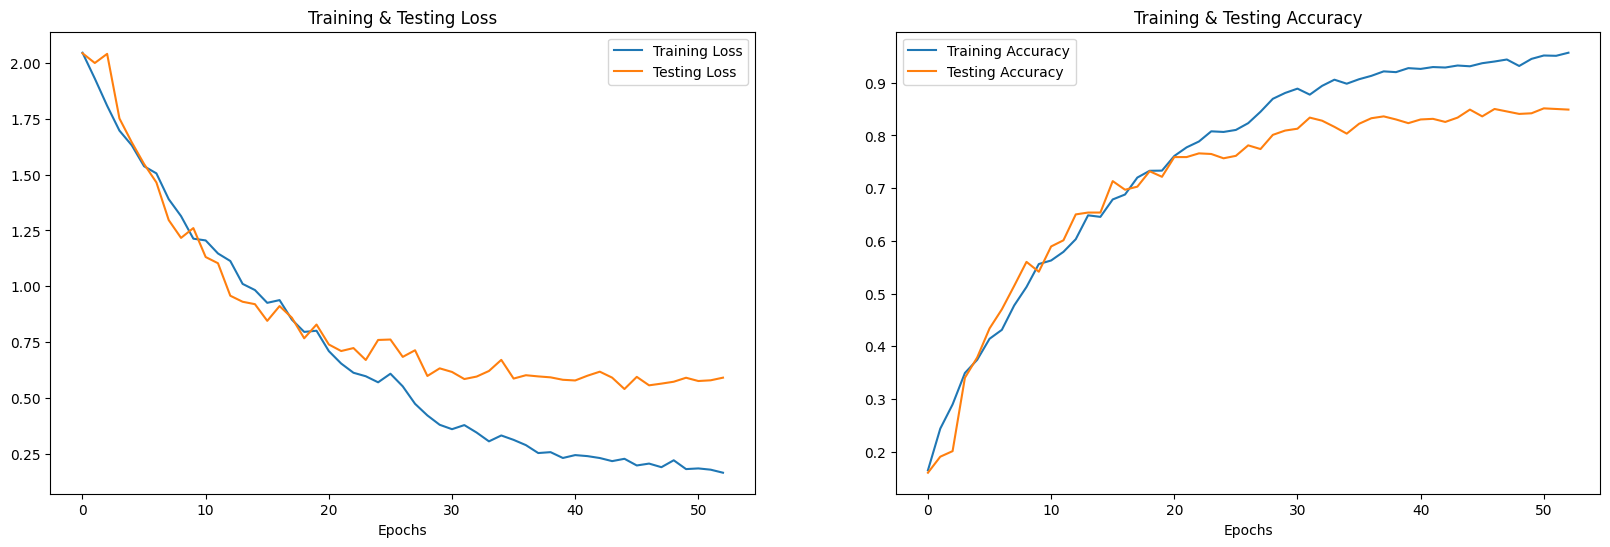

In [39]:
print("Accuracy of our model on test data : " , model.evaluate(x_test, y_test)[1] * 100, "%")

epochs = [i for i in range(len(history.history['loss']))]

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(20, 6)

train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

ax[0].plot(epochs, train_loss, label='Training Loss')
ax[0].plot(epochs, test_loss, label='Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs, train_acc, label='Training Accuracy')
ax[1].plot(epochs, test_acc, label='Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")

plt.show()

In [40]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

27/27 [==============================] - 3s 81ms/step


In [41]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

Predicted Labels Actual Labels
0            angry         angry
1             calm          calm
2         surprise      surprise
3             fear          fear
4             calm           sad
5          disgust       disgust
6          disgust       disgust
7             calm          calm
8            angry         angry
9          neutral         angry

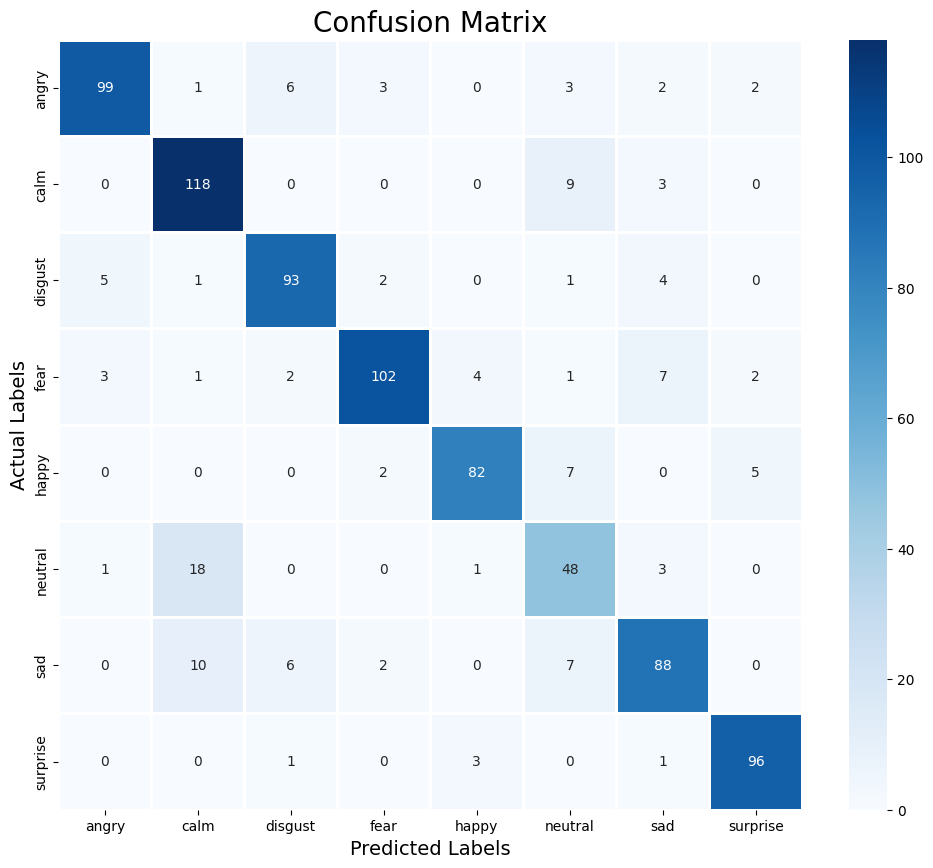

In [42]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [43]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.92      0.85      0.88       116
        calm       0.79      0.91      0.85       130
     disgust       0.86      0.88      0.87       106
        fear       0.92      0.84      0.88       122
       happy       0.91      0.85      0.88        96
     neutral       0.63      0.68      0.65        71
         sad       0.81      0.78      0.80       113
    surprise       0.91      0.95      0.93       101

    accuracy                           0.85       855
   macro avg       0.85      0.84      0.84       855
weighted avg       0.85      0.85      0.85       855

